In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import numpy as np

import community.community_louvain as community_louvain

import base64
from secrets import *
import json

import time

import csv

import copy

sns.set(style="whitegrid", font_scale=2)

In [130]:
def addToNetwork(g, team_from, team_to, price):
    if g.has_edge(team_from, team_to):
        g[team_from][team_to]['value'] += price
        g[team_from][team_to]['count'] += 1
    else:
        g.add_edge(team_from, team_to, value = price, count = 1)
        
def fromCodeToName(title):
    title = title[:-1]
    switcher = {
        "GB": "Premier League (GBR)",
        "ES": "Liga (ESP)",
        "IT": "Serie A (ITA)",
        "L": "Bundesliga (DEU)",
        "FR": "Ligue1 (FRA)",
        "PO": "Liga Portugal (PRT)",
        "NL": "Eredivise (NLD)",
        "RU": "Prem'er-Liga (RUS)",
        "BE": "Pro League (BEL)",
        "A": "Fußball-Bundesliga (AUT)",
    }
    return switcher.get(title, None)

def fromCodeToInitials(title):
    ret = ''
    for x in title.split(' + '):
        x = x[:-1]
        switcher = {
            "GB": "GBR",
            "ES": "ESP",
            "IT": "ITA",
            "L": "DEU",
            "FR": "FRA",
            "PO": "PRT",
            "NL": "NLD",
            "RU": "RUS",
            "BE": "BEL",
            "A": "AUT",
        }
        ret += switcher.get(x, '')
        ret += '_'
    if len(ret) > 1:
        ret = ret [:-1]
        ret = ret.replace('_',',\n')
    return ret

In [3]:
SCRAPE_SEASONS = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
SCRAPE_LEAGUES = ['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'PO1', 'NL1', 'RU1', 'BE1', 'A1']
ds = '../dataset/transfers.csv'

In [4]:
Gs = {}
for season in SCRAPE_SEASONS:
    Gs[season] = nx.DiGraph()

isFirst = True
with open(ds, encoding="utf8") as ds_csv:
    csv_reader = csv.reader(ds_csv, delimiter=',')
    evaluated = []
    for row in csv_reader:
        if isFirst:
            isFirst = False
        elif row[22] not in evaluated and row[0] in SCRAPE_LEAGUES:
            graph = Gs[int(row[1])]
            evaluated.append(row[22])
            price = float(row[16]) if len(row[16]) > 0 else 0
            price /= 1000000
            if price > 0:               
                if not graph.has_node(row[4]):
                    graph.add_node(row[4], nation = row[5], league = row[0])
                else:
                    if graph.nodes()[row[4]]['league'] == None:
                        graph.nodes()[row[4]]['league'] = row[0]
                    
                if not graph.has_node(row[14]):
                    graph.add_node(row[14], nation = row[15], league = None)
                    
                if row[6] == 'in':
                    team_to = row[14]
                    nation_to = row[15]
                    team_from = row[4]
                    nation_from = row[5]
                else:
                    team_to = row[4]
                    nation_to = row[5]
                    team_from = row[14]
                    nation_from = row[15]
                addToNetwork(Gs[int(row[1])], team_from, team_to, price)
Gs

{2010: <networkx.classes.digraph.DiGraph at 0x1ea3873c7f0>,
 2011: <networkx.classes.digraph.DiGraph at 0x1ea3873cfa0>,
 2012: <networkx.classes.digraph.DiGraph at 0x1ea3873ca30>,
 2013: <networkx.classes.digraph.DiGraph at 0x1ea3873c6d0>,
 2014: <networkx.classes.digraph.DiGraph at 0x1ea3873cc40>,
 2015: <networkx.classes.digraph.DiGraph at 0x1ea3873c8b0>,
 2016: <networkx.classes.digraph.DiGraph at 0x1ea3873c460>,
 2017: <networkx.classes.digraph.DiGraph at 0x1ea38757c70>,
 2018: <networkx.classes.digraph.DiGraph at 0x1ea38757dc0>,
 2019: <networkx.classes.digraph.DiGraph at 0x1ea38757ca0>,
 2020: <networkx.classes.digraph.DiGraph at 0x1ea38757f70>,
 2021: <networkx.classes.digraph.DiGraph at 0x1ea38757fd0>}

In [5]:
totNodes = 0
for season in SCRAPE_SEASONS:
    graph = Gs[season]
    nodes = len(graph.nodes())
    
    if nodes > totNodes:
        totNodes = nodes
totNodes

535

In [6]:
totNodes = 0
totOp = {}
totGrossExpense = {}
totNetExpense = {}
for season in SCRAPE_SEASONS:
    graph = Gs[season]
    totOp[season] = 0
    totGrossExpense[season] = 0
    totNetExpense[season] = 0
    evaluatedNodes = 0
    for n in graph.nodes():
        if graph.nodes()[n]['league'] != None:
            evaluatedNodes += 1
            
            k_in = graph.in_degree(n, weight='count')
            k_out = graph.out_degree(n, weight='count')
            totOp[season] += (k_in + k_out)
            
            k_in = graph.in_degree(n, weight='value') #value
            k_out = graph.out_degree(n, weight='value') #value
            totGrossExpense[season] += k_out
            totNetExpense[season] += (k_out - k_in if k_out > k_in else 0)
    if evaluatedNodes > totNodes:
        totNodes = evaluatedNodes
        
avgNet_ = {}
avgGross_ = {}
avgOp_ = {}
totNet_ = {}
totGross_ = {}
totOp_ = {}
for season in SCRAPE_SEASONS:
    avgOp = round(totOp[season]/totNodes,2)
    avgGrossExpense = round(totGrossExpense[season]/totNodes,2)
    avgNetExpense = round(totNetExpense[season]/totNodes,2)
    
    avgNet_[season] = avgNetExpense
    avgGross_[season] = avgGrossExpense
    avgOp_[season] = avgOp
    totNet_[season] = totNetExpense[season]
    totGross_[season] = totGrossExpense[season]
    totOp_[season] = totOp[season]

In [7]:
totOp = {}
totGross = {}
totNet = {}

tmpLeagues = {}
for league in SCRAPE_LEAGUES:
    tmpLeagues[league] = 0
    
for season in SCRAPE_SEASONS:
    graph = Gs[season]
    totOp[season] = copy.deepcopy(tmpLeagues)
    totGross[season] = copy.deepcopy(tmpLeagues)
    totNet[season] = copy.deepcopy(tmpLeagues)
    for n in graph.nodes():
        if graph.nodes()[n]['league'] != None:
            k_in = graph.in_degree(n, weight='count')
            k_out = graph.out_degree(n, weight='count')
            totOp[season][graph.nodes()[n]['league']] += (k_in + k_out)
            
            k_in = graph.in_degree(n, weight='value')
            k_out = graph.out_degree(n, weight='value')
            totGross[season][graph.nodes()[n]['league']] += k_out
            totNet[season][graph.nodes()[n]['league']] += (k_out - k_in if k_out > k_in else 0)

In [8]:
def printBar(totValues, title):
    values = {}
    for league in SCRAPE_LEAGUES:
        values[league] = []
        for season in SCRAPE_SEASONS:
            values[league].append(round(totValues[season][league],2))

    width = 0.4
    plt.figure(figsize=(15, 10))
    plt.title(title)
    default_x_ticks = range(len(list(SCRAPE_SEASONS)))
    plt.xticks(default_x_ticks, list(SCRAPE_SEASONS))

    plt.bar(np.arange(len(SCRAPE_SEASONS)) - 0.2, values['GB1'], width, label=fromCodeToName('GB1'))

    current = [0 for _ in range(len(SCRAPE_SEASONS))]
    for i in range(1,len(SCRAPE_LEAGUES)):
        league = SCRAPE_LEAGUES[i]
        plt.bar(
            np.arange(len(SCRAPE_SEASONS)) + width - 0.2,
            values[league],
            width,
            label=fromCodeToName(league),
            bottom=current
        )
        current = [x + y for x, y in zip(current, values[league])]

    font = font_manager.FontProperties(size=16)
    plt.legend(prop=font)

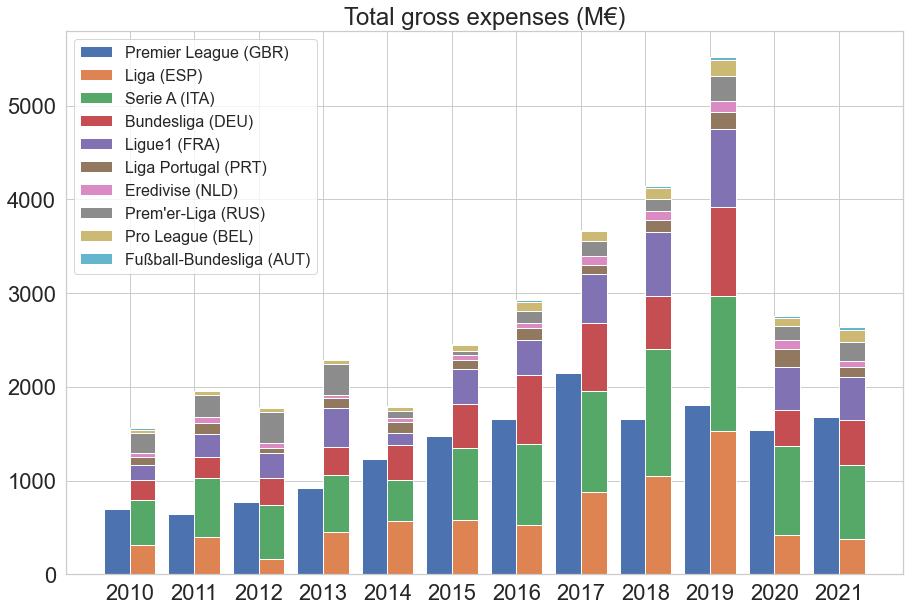

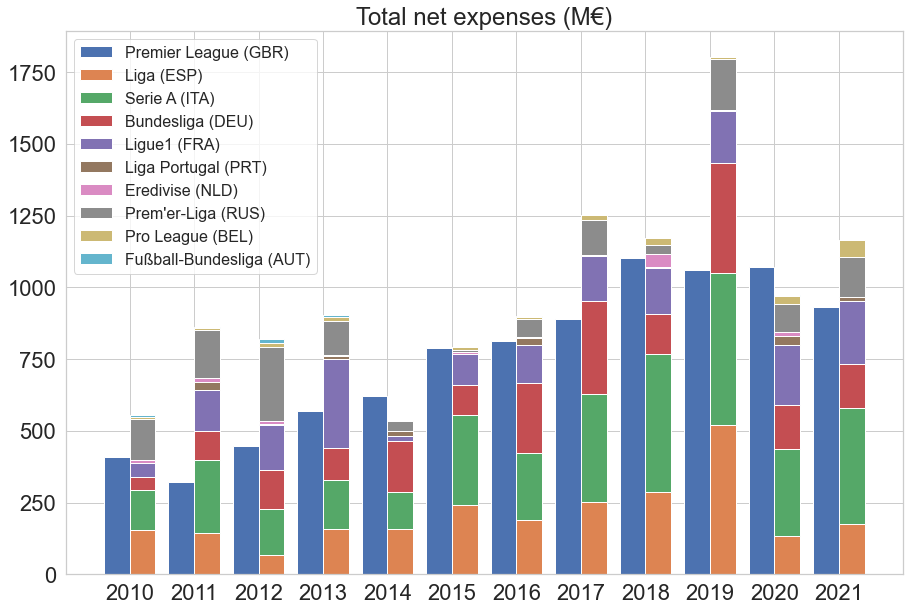

In [9]:
printBar(totGross, 'Total gross expenses (M€)')
printBar(totNet, 'Total net expenses (M€)')

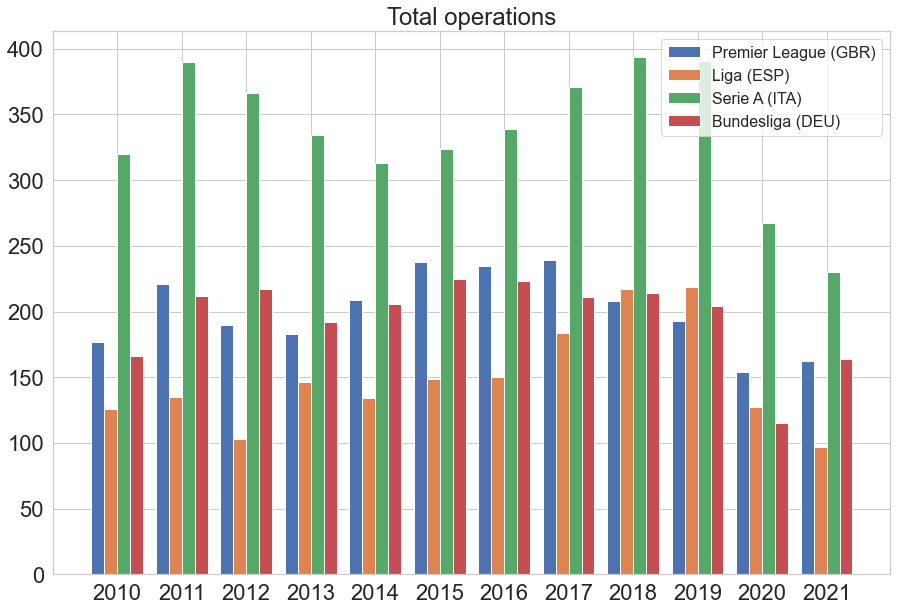

In [10]:
values = {}
for league in SCRAPE_LEAGUES:
    values[league] = []
    for season in SCRAPE_SEASONS:
        values[league].append(round(totOp[season][league],2))
        
width = 0.2
plt.figure(figsize=(15, 10))
plt.title('Total operations')
default_x_ticks = range(len(list(SCRAPE_SEASONS)))
plt.xticks(default_x_ticks, list(SCRAPE_SEASONS))

shift = 0.1
plt.bar(np.arange(len(SCRAPE_SEASONS)) - 0.2 - shift, values['GB1'], width, label=fromCodeToName('GB1'))
plt.bar(np.arange(len(SCRAPE_SEASONS)) - 0.2 + 0.2 - shift, values['ES1'], width, label=fromCodeToName('ES1'))
plt.bar(np.arange(len(SCRAPE_SEASONS)) - 0.2 + 0.4 - shift, values['IT1'], width, label=fromCodeToName('IT1'))
plt.bar(np.arange(len(SCRAPE_SEASONS)) - 0.2 + 0.6 - shift, values['L1'], width, label=fromCodeToName('L1'))

font = font_manager.FontProperties(size=16)
plt.legend(prop=font)

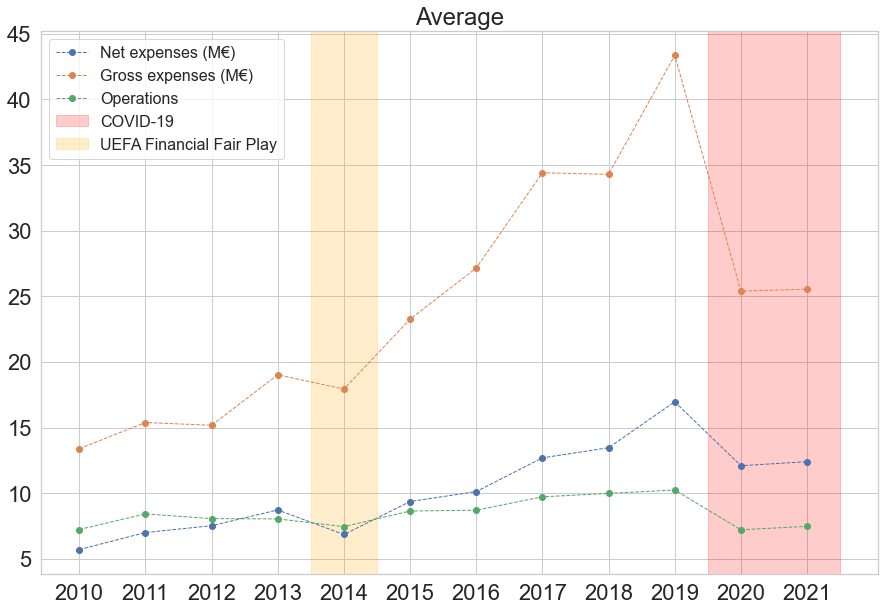

In [11]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(15, 10))

plt.plot(list(avgNet_.values()), label="Net expenses (M€)", marker='o', linestyle='dashed', linewidth=1, markersize=6)
plt.plot(list(avgGross_.values()), label="Gross expenses (M€)", marker='o', linestyle='dashed', linewidth=1, markersize=6)
plt.plot(list(avgOp_.values()), label="Operations", marker='o', linestyle='dashed', linewidth=1, markersize=6)

plt.title('Average')
default_x_ticks = range(len(list(SCRAPE_SEASONS)))
plt.xticks(default_x_ticks, list(SCRAPE_SEASONS))

plt.axvspan(9.5, 11.5, color="red", alpha=0.2, label="COVID-19")
plt.axvspan(3.5, 4.5, color="orange", alpha=0.2, label="UEFA Financial Fair Play")

font = font_manager.FontProperties(size=16)
plt.legend(prop=font)

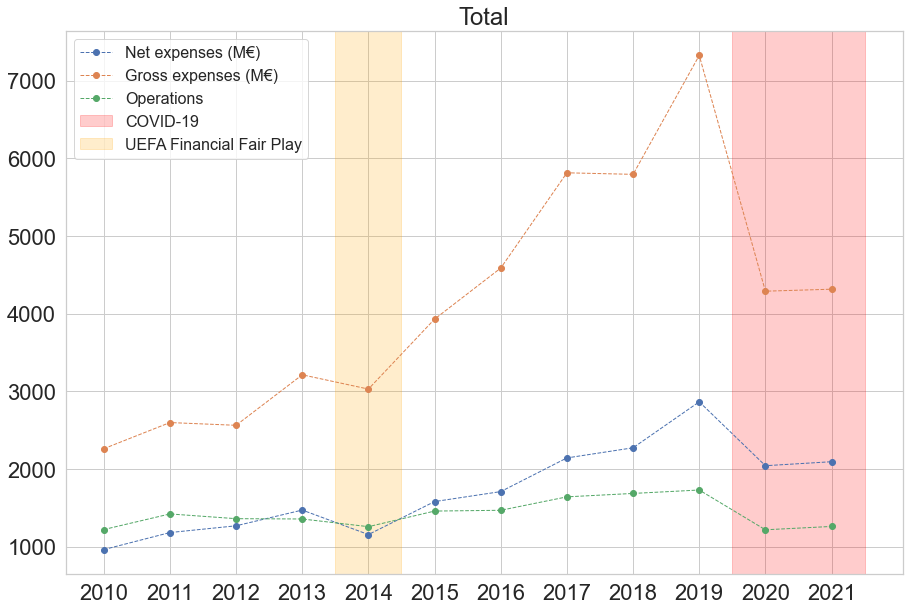

In [12]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(15, 10))

plt.plot(list(totNet_.values()), label="Net expenses (M€)", marker='o', linestyle='dashed', linewidth=1, markersize=6)
plt.plot(list(totGross_.values()), label="Gross expenses (M€)", marker='o', linestyle='dashed', linewidth=1, markersize=6)
plt.plot(list(totOp_.values()), label="Operations", marker='o', linestyle='dashed', linewidth=1, markersize=6)

plt.title('Total')
default_x_ticks = range(len(list(totNet_.keys())))
plt.xticks(default_x_ticks, list(totNet_.keys()))

plt.axvspan(9.5, 11.5, color="red", alpha=0.2, label="COVID-19")
plt.axvspan(3.5, 4.5, color="orange", alpha=0.2, label="UEFA Financial Fair Play")

font = font_manager.FontProperties(size=16)
plt.legend(prop=font)

In [13]:
def analyzeTopX(top, title):
    data = {}
    for team in top:    
        data[team] = []
        for season in SCRAPE_SEASONS:
            graph = Gs[season]
            k_in = graph.in_degree(team, weight='value')
            k_out = graph.out_degree(team, weight='value')
            if graph.has_node(team):
                delta = k_in - k_out
            else:
                delta = 0
            data[team].append(delta)

    width = 0.5
    sns.set(style="whitegrid", font_scale=2)

    plt.figure(figsize=(15, 15))
    plt.title(title)

    i = 0
    for team in top:
        plt.plot(data[team], label=team, marker='o', linestyle='dashed', linewidth=1, markersize=6)

    data = []
    for season in SCRAPE_SEASONS:
        graph = Gs[season]
        totSeason = 0
        for team in top:        
            k_in = graph.in_degree(team, weight='value')
            k_out = graph.out_degree(team, weight='value')
            if graph.has_node(team):
                delta = k_in - k_out
            else:
                delta = 0
            totSeason += delta
        data.append(totSeason / len(top))

    data_pos = [0 for _ in range(len(SCRAPE_SEASONS))]
    data_neg = [0 for _ in range(len(SCRAPE_SEASONS))]
    for i in range(len(SCRAPE_SEASONS)):
        if data[i] >= 0:
            data_pos[i] = data[i]
        else:
            data_neg[i] = data[i]
            
    plt.bar(np.arange(len(SCRAPE_SEASONS)), data_neg, width, color='r')
    plt.bar(np.arange(len(SCRAPE_SEASONS)), data_pos, width, color='g')

    default_x_ticks = range(len(list(totNet_.keys())))
    plt.xticks(default_x_ticks, list(totNet_.keys()))

    font = font_manager.FontProperties(size=16)
    plt.legend(prop=font)

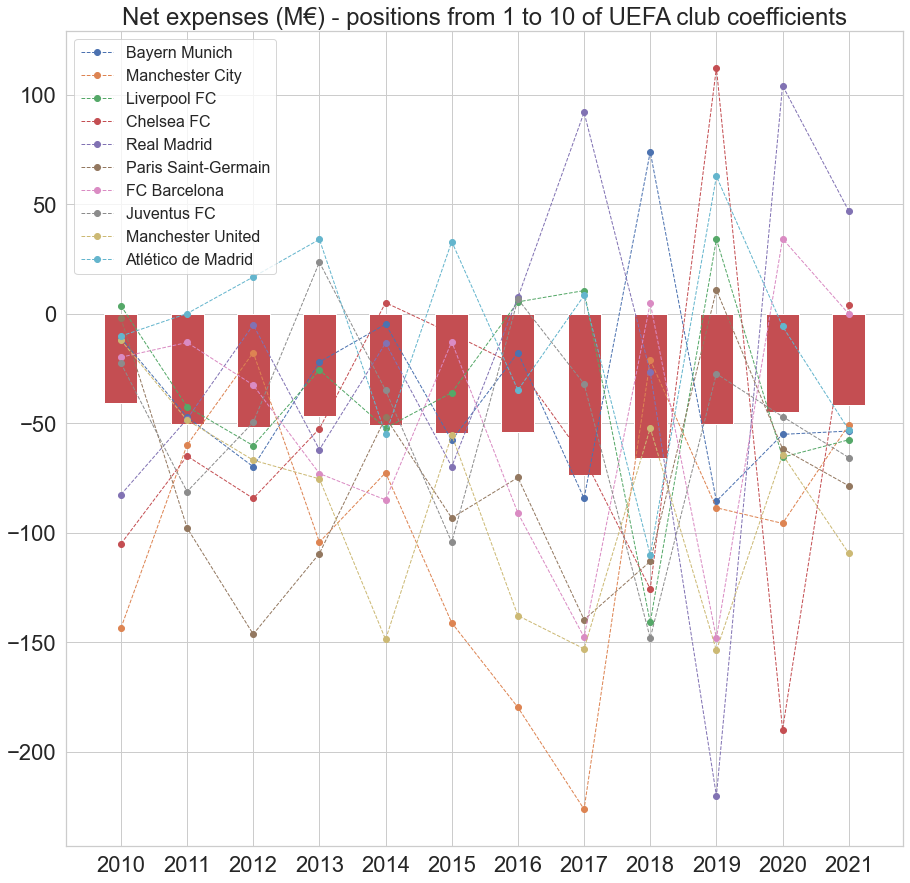

In [14]:
analyzeTopX(
    [
    'Bayern Munich',
    'Manchester City',
    'Liverpool FC',
    'Chelsea FC',
    'Real Madrid',
    'Paris Saint-Germain',
    'FC Barcelona',
    'Juventus FC',
    'Manchester United',
    'Atlético de Madrid'
    ],
    'Net expenses (M€) - positions from 1 to 10 of UEFA club coefficients'
)

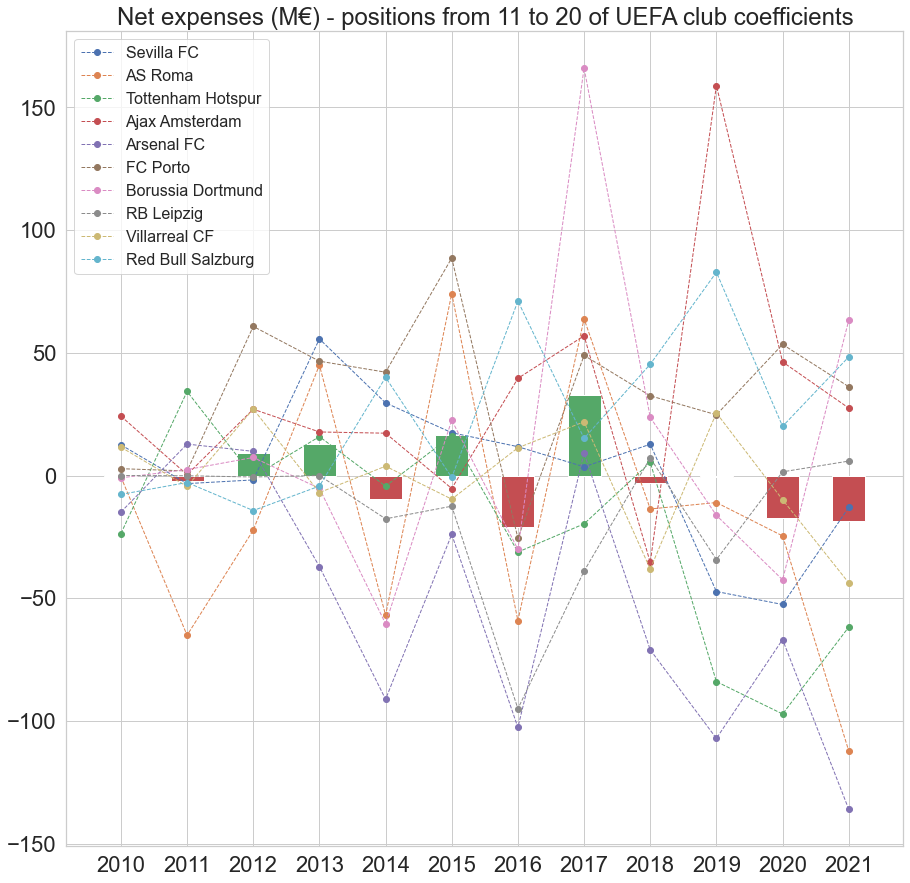

In [15]:
analyzeTopX(
    [
        'Sevilla FC',
        'AS Roma',
        'Tottenham Hotspur',
        'Ajax Amsterdam',
        'Arsenal FC',
        'FC Porto',
        'Borussia Dortmund',
        'RB Leipzig',
        'Villarreal CF',
        'Red Bull Salzburg',
    ],
    'Net expenses (M€) - positions from 11 to 20 of UEFA club coefficients'
)

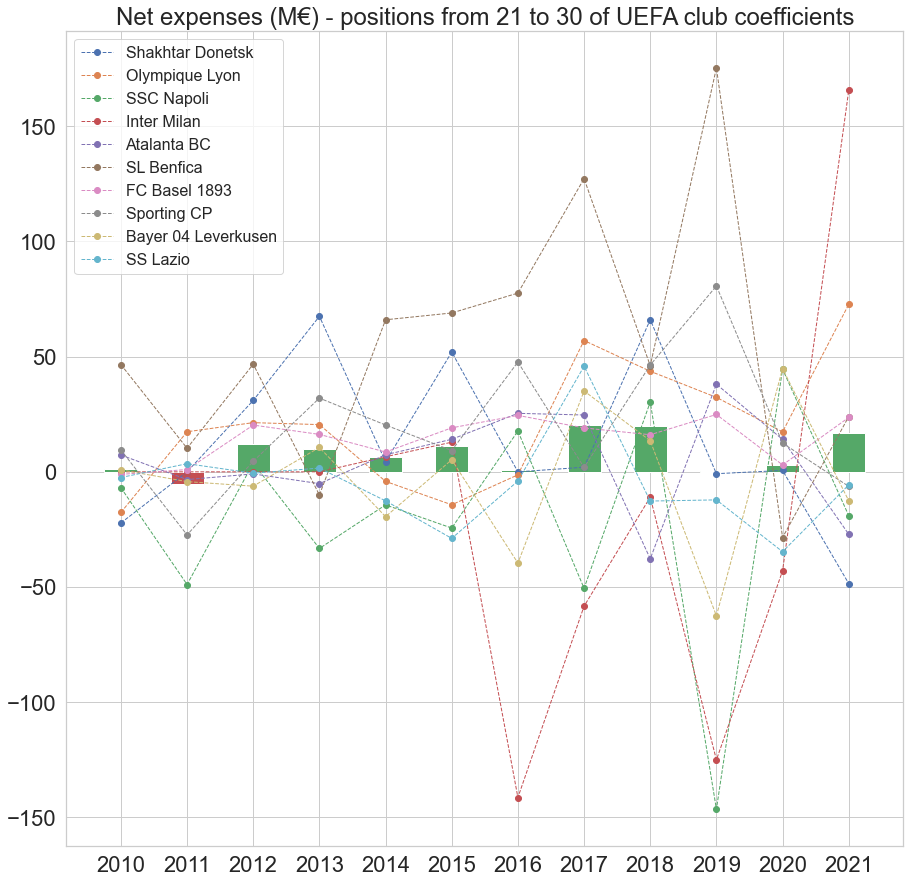

In [16]:
analyzeTopX(
    [
        'Shakhtar Donetsk',
        'Olympique Lyon',
        'SSC Napoli',
        'Inter Milan',
        'Atalanta BC',
        'SL Benfica',
        'FC Basel 1893',
        'Sporting CP',
        'Bayer 04 Leverkusen',
        'SS Lazio'
    ],
    'Net expenses (M€) - positions from 21 to 30 of UEFA club coefficients'
)

In [155]:
def myColorBar(data1, data2, numberOfComm):    
    plt.rcdefaults()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    
    im1 = ax1.imshow(data1, interpolation='nearest', aspect='auto', origin='lower')
    ax1.set_title("precision")
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(data2, interpolation='nearest', aspect='auto', origin='lower')
    ax2.set_title("recall")
    fig.colorbar(im2, ax=ax2)

    ax1.set_yticks(range(numberOfComm))
    ax1.set_yticklabels([f'C{i}' for i in range(numberOfComm)])
    ax1.set_xticks(range(len(SCRAPE_LEAGUES)))
    ax1.set_xticklabels([fromCodeToInitials(league) for league in SCRAPE_LEAGUES])

    ax2.set_yticks(range(numberOfComm))
    ax2.set_yticklabels([f'C{i}' for i in range(numberOfComm)])
    ax2.set_xticks(range(len(SCRAPE_LEAGUES)))
    ax2.set_xticklabels([fromCodeToInitials(league) for league in SCRAPE_LEAGUES])
 
    plt.show()

In [156]:
def newColorBar(matrix1, matrix2, numberOfComm):
    plt.rcdefaults()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    
    data1 = copy.deepcopy(matrix1)
    for i in range(numberOfComm):
        curMax = 0
        idMax = 0
        for j in range(numberOfComm):
            if matrix1[i][j] > curMax:
                curMax = matrix1[i][j]
                idMax = j
        data1[idMax] = matrix1[i]
        
    im1 = ax1.imshow(data1, interpolation='nearest', aspect='auto', origin='lower')
    ax1.set_title("precision")
    fig.colorbar(im1, ax=ax1)

    ax1.set_yticks(range(numberOfComm))
    ax1.set_yticklabels([f'C{i}' for i in range(numberOfComm)])
    ax1.set_xticks(range(len(LEAGUES)))
    ax1.set_xticklabels([fromCodeToInitials(league) for league in LEAGUES])
    
    data2 = copy.deepcopy(matrix2)
    for i in range(numberOfComm):
        curMax = 0
        idMax = 0
        for j in range(numberOfComm):
            if matrix2[i][j] > curMax:
                curMax = matrix2[i][j]
                idMax = j
        data2[idMax] = matrix2[i]
        
    im2 = ax2.imshow(data2, interpolation='nearest', aspect='auto', origin='lower')
    ax2.set_title("recall")
    fig.colorbar(im2, ax=ax2)

    ax2.set_yticks(range(numberOfComm))
    ax2.set_yticklabels([f'C{i}' for i in range(numberOfComm)])
    ax2.set_xticks(range(len(LEAGUES)))
    ax2.set_xticklabels([fromCodeToInitials(league) for league in LEAGUES])

    plt.show()

In [157]:
operations = nx.Graph()
values = nx.Graph()
for season in SCRAPE_SEASONS:
    graph = Gs[season]
    for node in graph.nodes():
        if not operations.has_node(node):
            operations.add_node(node)
            operations.nodes()[node]['league'] = graph.nodes()[node]['league']
        if not values.has_node(node):
            values.add_node(node)
            values.nodes()[node]['league'] = graph.nodes()[node]['league']
        
    for f, t in graph.edges():
        tmpCount =  graph[f][t]['count']
        tmpValue =  graph[f][t]['value']
        
        if operations.has_edge(f, t):
            operations[f][t]['weight'] += tmpCount
        else:
            operations.add_edge(f, t, weight = tmpCount)
            
        if values.has_edge(f, t):
            values[f][t]['weight'] += tmpValue
        else:
            values.add_edge(f, t, weight = tmpValue)

In [119]:
if False:
    op_louvain = community_louvain.best_partition(operations)
    op_numberOfComm = max(op_louvain.values()) + 1

In [120]:
if False:
    val_louvain = community_louvain.best_partition(values)
    val_numberOfComm = max(val_louvain.values()) + 1

In [158]:
op_m = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(op_numberOfComm)]
op_p = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(op_numberOfComm)]
op_r = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(op_numberOfComm)]
val_m = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(val_numberOfComm)]
val_p = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(val_numberOfComm)]
val_r = [[0 for _ in range(len(SCRAPE_LEAGUES))] for _ in range(val_numberOfComm)]

for n in operations.nodes():
    i = op_louvain[n]
    op_tmp = operations.nodes()[n]['league']
    if op_tmp != None:
        j = SCRAPE_LEAGUES.index(op_tmp)
        op_m[i][j] += 1 
        
for n in values.nodes():
    i = val_louvain[n]
    val_tmp = values.nodes()[n]['league']
    if val_tmp != None:
        j = SCRAPE_LEAGUES.index(val_tmp)
        val_m[i][j] += 1 
        
op_c = [0 for _ in range(op_numberOfComm)]
op_l = [0 for _ in range(len(SCRAPE_LEAGUES))]
val_c = [0 for _ in range(val_numberOfComm)]
val_l = [0 for _ in range(len(SCRAPE_LEAGUES))]

for i in range(op_numberOfComm):
    op_c[i] = sum(op_m[i])
for i in range(val_numberOfComm):
    val_c[i] = sum(val_m[i])

for j in range(len(SCRAPE_LEAGUES)):
    for i in range(op_numberOfComm):
        op_l[j] += op_m[i][j]
    for i in range(val_numberOfComm):
        val_l[j] += val_m[i][j]

for i in range(op_numberOfComm):
    for j in range(len(SCRAPE_LEAGUES)):
        op_p[i][j] = op_m[i][j] / op_c[i]
        op_r[i][j] = op_m[i][j] / op_l[j]
for i in range(val_numberOfComm):
    for j in range(len(SCRAPE_LEAGUES)):
        val_p[i][j] = val_m[i][j] / val_c[i]
        val_r[i][j] = val_m[i][j] / val_l[j]

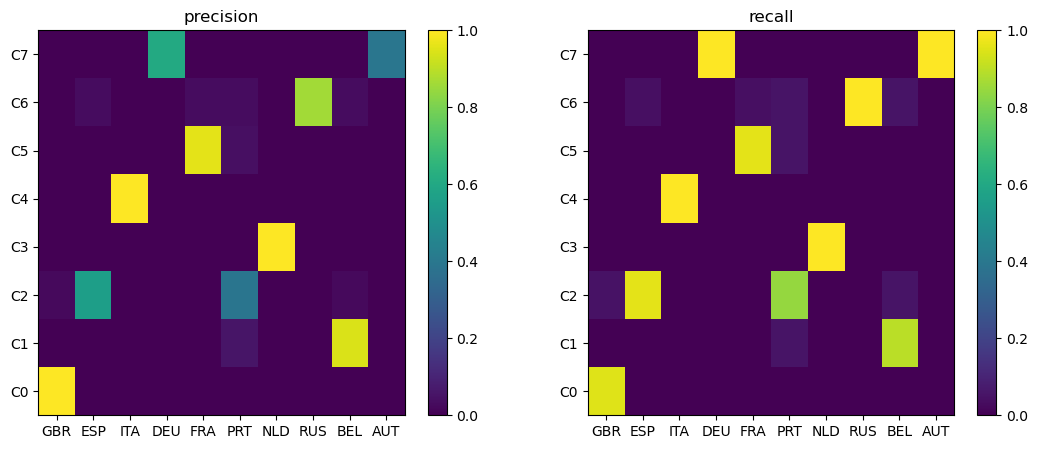

In [159]:
myColorBar(
    op_p,
    op_r,
    op_numberOfComm
)

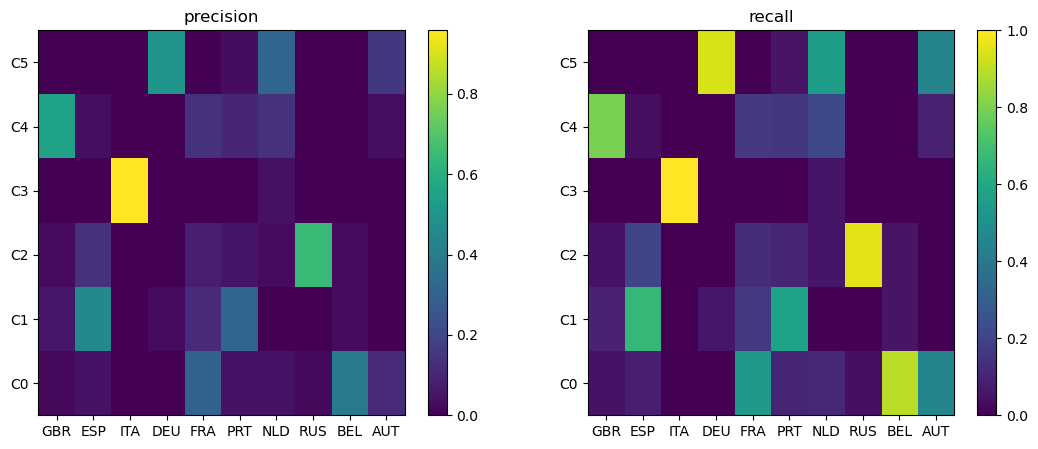

In [160]:
myColorBar(
    val_p,
    val_r,
    val_numberOfComm
)

In [150]:
LEAGUES = ['GB1', 'ES1 + PO1', 'IT1', 'L1 + A1', 'FR1', 'NL1', 'RU1', 'BE1']

op_m = [[0 for _ in range(len(LEAGUES))] for _ in range(op_numberOfComm)]
op_p = [[0 for _ in range(len(LEAGUES))] for _ in range(op_numberOfComm)]
op_r = [[0 for _ in range(len(LEAGUES))] for _ in range(op_numberOfComm)]

compactOperations = copy.deepcopy(operations)

for n in compactOperations.nodes():
    i = op_louvain[n]
    op_tmp = compactOperations.nodes()[n]['league']
    if op_tmp != None:
        if op_tmp in ['ES1', 'PO1']:
            op_tmp = 'ES1 + PO1'
        if op_tmp in ['L1', 'A1']:
            op_tmp = 'L1 + A1'
        j = LEAGUES.index(op_tmp)
        op_m[i][j] += 1 
        
op_c = [0 for _ in range(op_numberOfComm)]
op_l = [0 for _ in range(len(LEAGUES))]

for i in range(op_numberOfComm):
    op_c[i] = sum(op_m[i])

for j in range(len(LEAGUES)):
    for i in range(op_numberOfComm):
        op_l[j] += op_m[i][j]

for i in range(op_numberOfComm):
    for j in range(len(LEAGUES)):
        op_p[i][j] = op_m[i][j] / op_c[i]
        op_r[i][j] = op_m[i][j] / op_l[j]

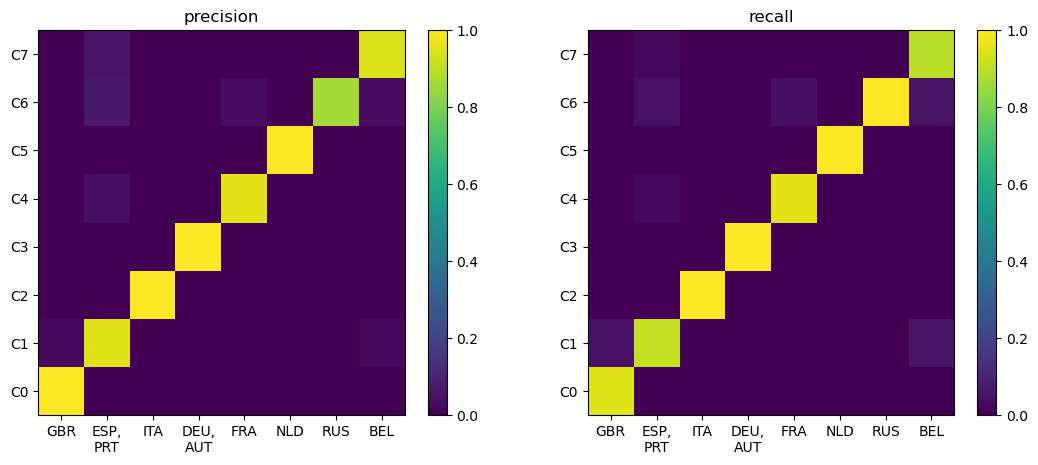

In [151]:
LEAGUES = ['GB1', 'ES1 + PO1', 'IT1', 'L1 + A1', 'FR1', 'NL1', 'RU1', 'BE1']

newColorBar(op_p, op_r, op_numberOfComm)

In [152]:
LEAGUES = ['GB1 + NL1', 'ES1 + PO1', 'IT1', 'L1 + A1', 'FR1 + BE1', 'RU1']

val_m = [[0 for _ in range(len(LEAGUES))] for _ in range(val_numberOfComm)]
val_p = [[0 for _ in range(len(LEAGUES))] for _ in range(val_numberOfComm)]
val_r = [[0 for _ in range(len(LEAGUES))] for _ in range(val_numberOfComm)]

compactValues = copy.deepcopy(values)

for n in compactValues.nodes():
    i = val_louvain[n]
    val_tmp = compactValues.nodes()[n]['league']
    if val_tmp != None:
        if val_tmp in ['ES1', 'PO1']:
            val_tmp = 'ES1 + PO1'
        if val_tmp in ['L1', 'A1']:
            val_tmp = 'L1 + A1'
        if val_tmp in ['GB1', 'NL1']:
            val_tmp = 'GB1 + NL1'
        if val_tmp in ['FR1', 'BE1']:
            val_tmp = 'FR1 + BE1'
        j = LEAGUES.index(val_tmp)
        val_m[i][j] += 1 
        
val_c = [0 for _ in range(val_numberOfComm)]
val_l = [0 for _ in range(len(LEAGUES))]

for i in range(val_numberOfComm):
    val_c[i] = sum(val_m[i])

for j in range(len(LEAGUES)):
    for i in range(val_numberOfComm):
        val_l[j] += val_m[i][j]

for i in range(val_numberOfComm):
    for j in range(len(LEAGUES)):
        val_p[i][j] = val_m[i][j] / val_c[i]
        val_r[i][j] = val_m[i][j] / val_l[j]

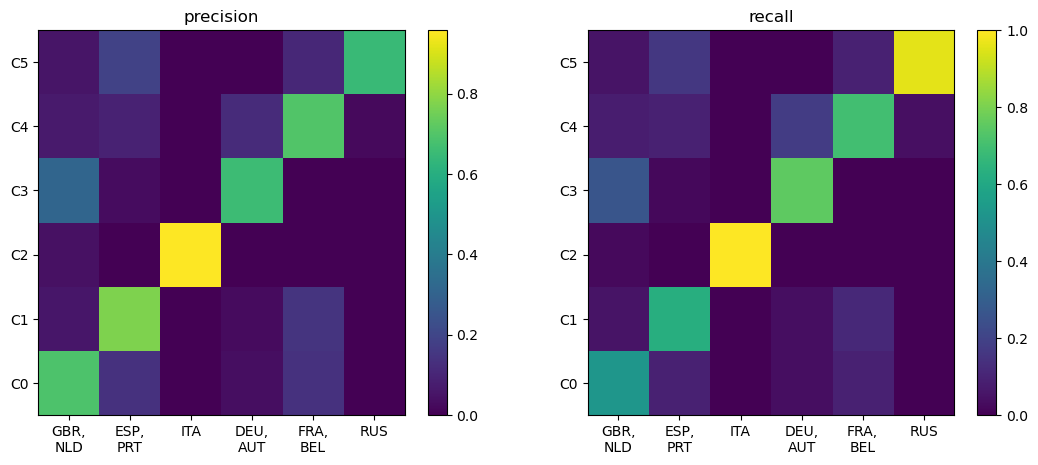

In [153]:
LEAGUES = ['GB1 + NL1', 'ES1 + PO1', 'IT1', 'L1 + A1', 'FR1 + BE1', 'RU1']

newColorBar(val_p, val_r, val_numberOfComm)

In [161]:
operations = nx.Graph()
values = nx.Graph()
for season in SCRAPE_SEASONS:
    graph = Gs[season]
    for node in graph.nodes():
        if not operations.has_node(node):
            operations.add_node(node)
            operations.nodes()[node]['league'] = graph.nodes()[node]['league']
            operations.nodes()[node]['louvain'] = op_louvain[node]
        if not values.has_node(node):
            values.add_node(node)
            values.nodes()[node]['league'] = graph.nodes()[node]['league']
            values.nodes()[node]['louvain'] = val_louvain[node]
        
    for f, t in graph.edges():
        tmpCount =  graph[f][t]['count']
        tmpValue =  graph[f][t]['value']
        
        if operations.has_edge(f, t):
            operations[f][t]['weight'] += tmpCount
        else:
            operations.add_edge(f, t, weight = tmpCount)
            
        if values.has_edge(f, t):
            values[f][t]['weight'] += tmpValue
        else:
            values.add_edge(f, t, weight = tmpValue)

In [168]:
def plotCentralities(graph):
    btw = {
        'Bayern Munich': 0,
        'Manchester City': 0,
        'Liverpool FC': 0,
        'Chelsea FC': 0,
        'Real Madrid': 0,
        'Paris Saint-Germain': 0,
        'FC Barcelona': 0,
        'Juventus FC': 0,
        'Manchester United': 0,
        'Atlético de Madrid': 0,
        'Sevilla FC': 0,
        'AS Roma': 0,
        'Tottenham Hotspur': 0,
        'Ajax Amsterdam': 0,
        'Arsenal FC': 0,
        'FC Porto': 0,
        'Borussia Dortmund': 0,
        'RB Leipzig': 0,
        'Villarreal CF': 0,
        'Red Bull Salzburg': 0,
        'Shakhtar Donetsk': 0,
        'Olympique Lyon': 0,
        'SSC Napoli': 0,
        'Inter Milan': 0,
        'Atalanta BC': 0,
        'SL Benfica': 0,
        'FC Basel 1893': 0,
        'Sporting CP': 0,
        'Bayer 04 Leverkusen': 0,
        'SS Lazio': 0
    }
    btw = {k: btw[k] for k in list(btw.keys())[::-1]}
    wgt = copy.deepcopy(btw)
    egv = copy.deepcopy(btw)
    cls = copy.deepcopy(btw)

    tmpBtw = nx.betweenness_centrality(graph, weight='weight')
    for key in btw:
        btw[key] = tmpBtw[key]

    for key in wgt:
        wgt[key] = graph.degree(key, weight='weight')

    tmpEgv = nx.eigenvector_centrality(graph, weight='weight')
    for key in egv:
        egv[key] = tmpEgv[key]

    tmpCls = nx.closeness_centrality(graph)
    for key in cls:
        cls[key] = tmpCls[key]
        
    plt.rcdefaults()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,9))

    teams = [
        'Bayern Munich',
        'Manchester City',
        'Liverpool FC',
        'Chelsea FC',
        'Real Madrid',
        'Paris Saint-Germain',
        'FC Barcelona',
        'Juventus FC',
        'Manchester United',
        'Atlético de Madrid',
        'Sevilla FC',
        'AS Roma',
        'Tottenham Hotspur',
        'Ajax Amsterdam',
        'Arsenal FC',
        'FC Porto',
        'Borussia Dortmund',
        'RB Leipzig',
        'Villarreal CF',
        'Red Bull Salzburg',
        'Shakhtar Donetsk',
        'Olympique Lyon',
        'SSC Napoli',
        'Inter Milan',
        'Atalanta BC',
        'SL Benfica',
        'FC Basel 1893',
        'Sporting CP',
        'Bayer 04 Leverkusen',
        'SS Lazio'
    ]
    teams.reverse()

    y_pos = np.arange(len(teams))

    ax1.barh(
        y_pos,
        list(btw.values()),
        color='blue'
    )
    ax2.barh(
        y_pos,
        list(egv.values()),
        color='c'
    )
    ax3.barh(
        y_pos,
        list(cls.values()),
        color='y'
    )
    ax4.barh(
        y_pos,
        list(wgt.values()),
        color='orange'
    )

    ax1.set_yticks(range(len(teams)))
    ax1.set_yticklabels(teams)
    ax2.axes.get_yaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])
    ax4.yaxis.tick_right()
    ax4.set_yticks(range(len(teams)))
    ax4.set_yticklabels(teams)

    ax1.set_title('betweenness')
    ax2.set_title('eigenvector')
    ax3.set_title('closeness')
    ax4.set_title('degree')

    plt.show()

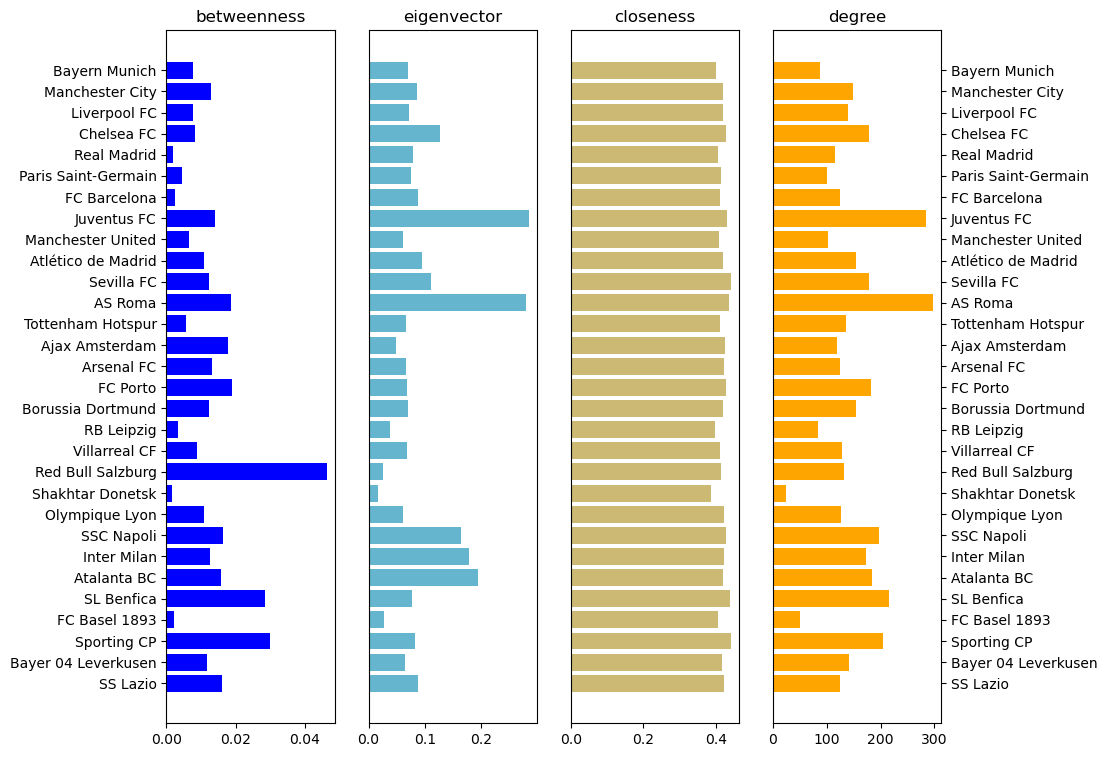

In [169]:
plotCentralities(operations)

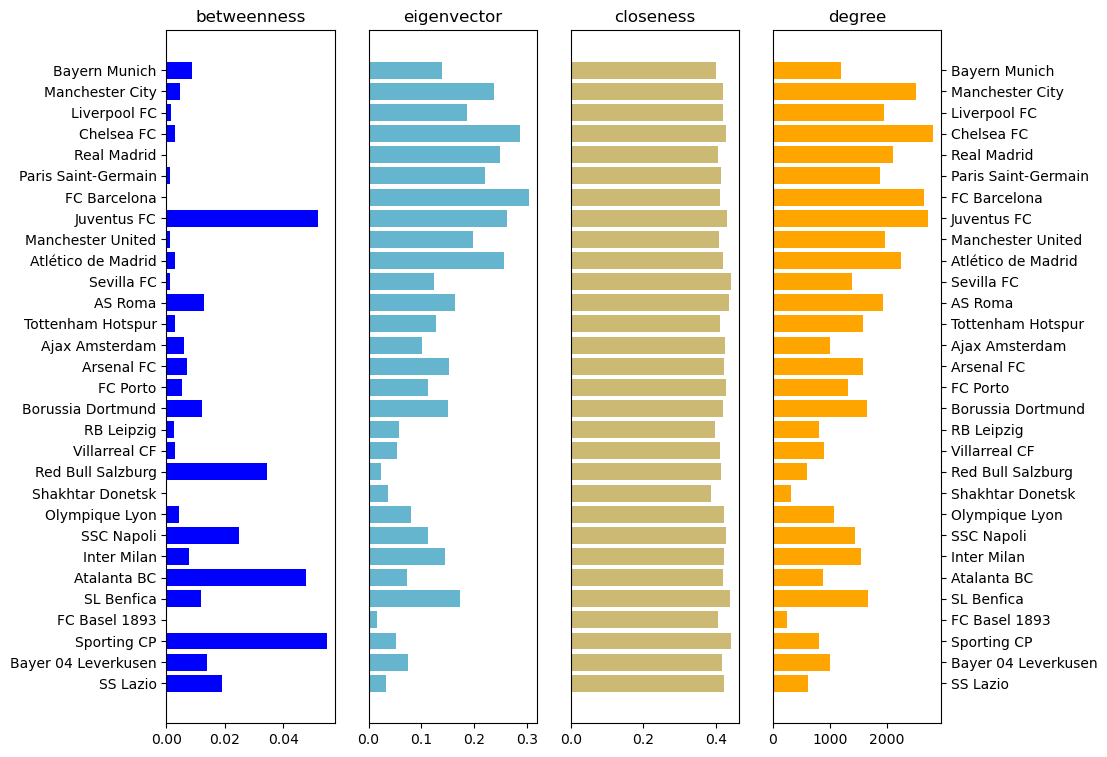

In [170]:
plotCentralities(values)

In [171]:
export = copy.deepcopy(operations)
for n in export.nodes():
    if export.nodes()[n]['league'] == None:
        export.nodes()[n]['league'] = ''
nx.write_gexf(export, f'..\\gephi\\operations.gexf')

export = copy.deepcopy(values)
for n in export.nodes():
    if export.nodes()[n]['league'] == None:
        export.nodes()[n]['league'] = ''
nx.write_gexf(export, f'..\\gephi\\values.gexf')

In [175]:
graph = operations
#for key in wgt:
key = 'Chelsea FC'
print(graph.degree(key, weight='weight'))
#    = graph.degree(key, weight='weight')

179
